# Case 2: Collaborative Filtering via Deep Learning
-----

In this case, there are two main tasks:

- First, you need to build a deep learning model to predict the movie ratings.

- Then you will analyze the predicted ratings and provide an estimate of the movie valuation.

## Instructions

You need to fill in the missing code and submit the following files on Canvas
site:

1. A report in the pdf format containing the plots and the answers to the questions stated in the provided Jupyter notebook (Please read carefully the notebook and make sure answer every question);

2. The complete Jupyter notebook containing all your PyTorch code with explanations, along with
a Markdown text explaining different parts if needed.

---
## Introduction

One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.



---
In this case, we'll build an explicit feedback recommender system: that is, a model that takes into account explicit feedback signals (like ratings) to recommend new content. We'll use an approach first made popular by the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize) contest: [matrix factorization](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf).

The basic idea is very simple:

1. Start with user-item-rating triplets, conveying the information that user _i_ gave some item _j_ rating _r_.
2. Represent both users and items as high-dimensional vectors of numbers. For example, a user could be represented by `[0.3, -1.2, 0.5]` and an item by `[1.0, -0.3, -0.6]`.
3. The representations should be chosen so that, when we multiplied together (via [dot products](https://en.wikipedia.org/wiki/Dot_product)), we can recover the original ratings.
4. The utility of the model then is derived from the fact that if we multiply the user vector of a user with the item vector of some item they _have not_ rated, we hope to obtain a predicition for the rating they would have given to it had they seen it.

<img src='https://storage.googleapis.com/gweb-cloudblog-publish/images/f1-collab_filtering.max-900x900.png?raw=true' width=50% />

We do not have access to Netflix's entire dataset of movie watching history, but there is a great dataset that we can use, called [MovieLens](https://grouplens.org/datasets/movielens/). This dataset contains tens of millions of movie rankings (a combination of a movie ID, a user ID, and a numeric rating).

We start with importing the [Movielens 1M dataset](https://grouplens.org/datasets/movielens/1M/).  It contains 1,000,209 anonymous ratings of approximately 3,706 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

## Preparations

We first import the packages and download the data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed if not on colab:
data_folder = '/content/'


ML_1M_URL = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-1m')

In [2]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

Extracting /content/ml-1m.zip to /content/ml-1m...


There are four different files:

- README
- movies.dat
- ratings.dat
- users.dat

You may read README to get the description of each dat files.

## Data analysis and formating

We start by loading the data with [Python Data Analysis Library](http://pandas.pydata.org/)

Note that the columns are separated by :: in the data.

In [3]:
import pandas as pd
all_ratings = pd.read_csv(op.join(ML_1M_FOLDER, 'ratings.dat'), sep='::',
                          names=["user_id", "item_id", "ratings", "timestamp"],engine='python')
all_ratings.head()

,user_id,item_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


When showing the data, we would rather see movie titles than their IDs. The `movies.dat` contains the correspondence of IDs to movie titles.

In [4]:
list_movies_names = []
list_item_ids = []
with open(op.join(ML_1M_FOLDER, 'movies.dat'), encoding = "ISO-8859-1") as fp:
    for line in fp:
        list_item_ids.append(line.split('::')[0])
        list_movies_names.append(line.split('::')[1])

movies_names = pd.DataFrame(list(zip(list_item_ids, list_movies_names)),
               columns =['item_id', 'item_name'])
movies_names.head()

,item_id,item_name
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Here we add the title of the movies to the `all_ratings` data.

In [5]:
movies_names['item_id']=movies_names['item_id'].astype(int)
all_ratings['item_id']=all_ratings['item_id'].astype(int)
all_ratings = all_ratings.merge(movies_names,on='item_id')

In [6]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975)
1,1,661,3,978302109,James and the Giant Peach (1996)
2,1,914,3,978301968,My Fair Lady (1964)
3,1,3408,4,978300275,Erin Brockovich (2000)
4,1,2355,5,978824291,"Bug's Life, A (1998)"


The dataframe `all_ratings` contains all the raw data for our problem.

In [7]:
#number of entries
len(all_ratings)

1000209

In [8]:
# statistics of ratings
all_ratings['ratings'].describe()

,ratings
count,1.000209e+06
mean,3.581564e+00
std,1.117102e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [9]:
# The ratings are 1, 2, 3, 4, 5
all_ratings['ratings'].unique()

array([5, 3, 4, 2, 1])

We now check the user IDs.

In [10]:
all_ratings['user_id'].describe()

,user_id
count,1.000209e+06
mean,3.024512e+03
std,1.728413e+03
min,1.000000e+00
25%,1.506000e+03
50%,3.070000e+03
75%,4.476000e+03
max,6.040000e+03


In [11]:
# number of unique users
total_user_id = len(all_ratings['user_id'].unique())
print(total_user_id)

6040


We see that  the users seem to be indexed from 1 to 6040. Let's check that below using the following code.

In [12]:
list_user_id = list(all_ratings['user_id'].unique())
list_user_id.sort()

In [13]:
for i,j in enumerate(list_user_id):
    if j != i+1:
        print(i,j)

We can see that `list_user_id` contains contiguous indices from 1 to 6040.

We create a new column `user_num` to get an index from 0 to 6039 for users:

In [14]:
all_ratings['user_num'] = all_ratings['user_id'].apply(lambda x :x-1)

In [15]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0
1,1,661,3,978302109,James and the Giant Peach (1996),0
2,1,914,3,978301968,My Fair Lady (1964),0
3,1,3408,4,978300275,Erin Brockovich (2000),0
4,1,2355,5,978824291,"Bug's Life, A (1998)",0


We now look at movies.

In [16]:
all_ratings['item_id'].describe()

,item_id
count,1.000209e+06
mean,1.865540e+03
std,1.096041e+03
min,1.000000e+00
25%,1.030000e+03
50%,1.835000e+03
75%,2.770000e+03
max,3.952000e+03


In [17]:
# number of unique rated items
total_item_id = len(all_ratings['item_id'].unique())
print(total_item_id)

3706


Here there is a clear problem: there are 3706 different movies but the range of `item_id` starts at 1 and ends at 3952. So there are gaps, so the first thing you will need to do is to create a new column `item_num` so that all movies are indexed from 0 to 3705.

In [18]:
itemnum_2_itemid = list(all_ratings['item_id'].unique())
itemnum_2_itemid.sort()
itemid_2_itemnum = {c:i for i,c in enumerate(itemnum_2_itemid)}
all_ratings['item_num'] = all_ratings['item_id'].apply(lambda x: itemid_2_itemnum[x])

This function will verify that we have created `item_num` correctly.

In [19]:
def check_ratings_num(df):
    item_num = set(df['item_num'])
    if item_num == set(range(len(item_num))):
        return True
    else:
        return False

In [20]:
check_ratings_num(all_ratings)

True

In [21]:
all_ratings.head()

,user_id,item_id,ratings,timestamp,item_name,user_num,item_num
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),0,1104
1,1,661,3,978302109,James and the Giant Peach (1996),0,639
2,1,914,3,978301968,My Fair Lady (1964),0,853
3,1,3408,4,978300275,Erin Brockovich (2000),0,3177
4,1,2355,5,978824291,"Bug's Life, A (1998)",0,2162


### Preliminary data analysis

**Exercises**: Find the top 10 most popular movies in the dataset and include the result in your report

In [22]:
import pandas as pd

# Assuming all_ratings is your DataFrame
# Group by item_id (movie ID) and count the number of ratings for each movie
movie_popularity = all_ratings.groupby('item_id')['ratings'].count()

# Convert the Series to a DataFrame
movie_popularity = movie_popularity.reset_index()

# Sort the movies by the count in descending order
sorted_movies = movie_popularity.sort_values(by='ratings', ascending=False)

# Get the top 10 most popular movies
top_10_movies = sorted_movies.head(10)

# Since you also need movie titles, you can merge this information with the movies_names DataFrame
top_10_movies = top_10_movies.merge(movies_names, on='item_id')

# Display the top 10 most popular movies
print(top_10_movies)

   item_id  ratings                                          item_name
0     2858     3428                             American Beauty (1999)
1      260     2991          Star Wars: Episode IV - A New Hope (1977)
2     1196     2990  Star Wars: Episode V - The Empire Strikes Back...
3     1210     2883  Star Wars: Episode VI - Return of the Jedi (1983)
4      480     2672                               Jurassic Park (1993)
5     2028     2653                         Saving Private Ryan (1998)
6      589     2649                  Terminator 2: Judgment Day (1991)
7     2571     2590                                 Matrix, The (1999)
8     1270     2583                          Back to the Future (1985)
9      593     2578                   Silence of the Lambs, The (1991)


**Exercise**: Plot the histogram of popularity (x-axis: # of given ratings, y-axis: # of movies with the given # of ratings). Include the plot in your report.

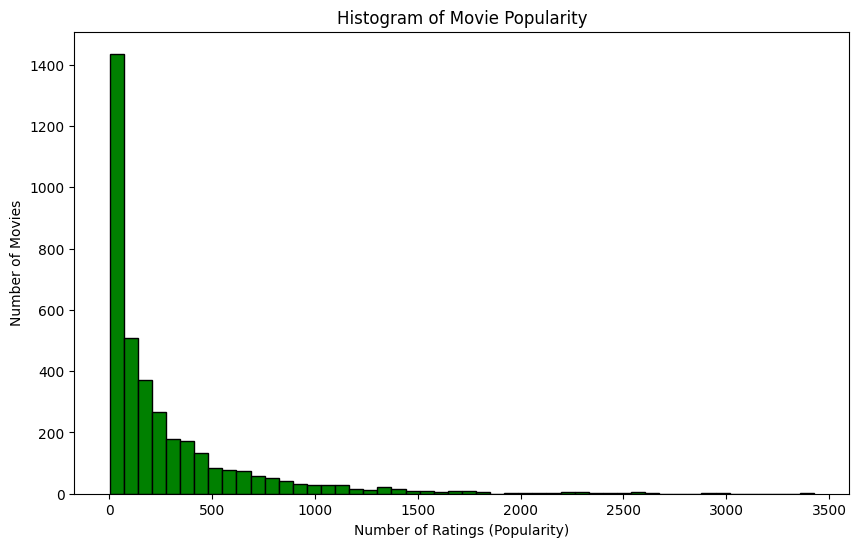

In [23]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(movie_popularity['ratings'], bins=50, edgecolor='black', color='green')  # Changed color to green

# Adding titles and labels
plt.title('Histogram of Movie Popularity')
plt.xlabel('Number of Ratings (Popularity)')
plt.ylabel('Number of Movies')

# Show the plot
plt.show()


**Exercise**: Plot the histogram of user activity (x-axis: # of given ratings, y-axis: # of users with the given # of ratings). Include the plot in your report.

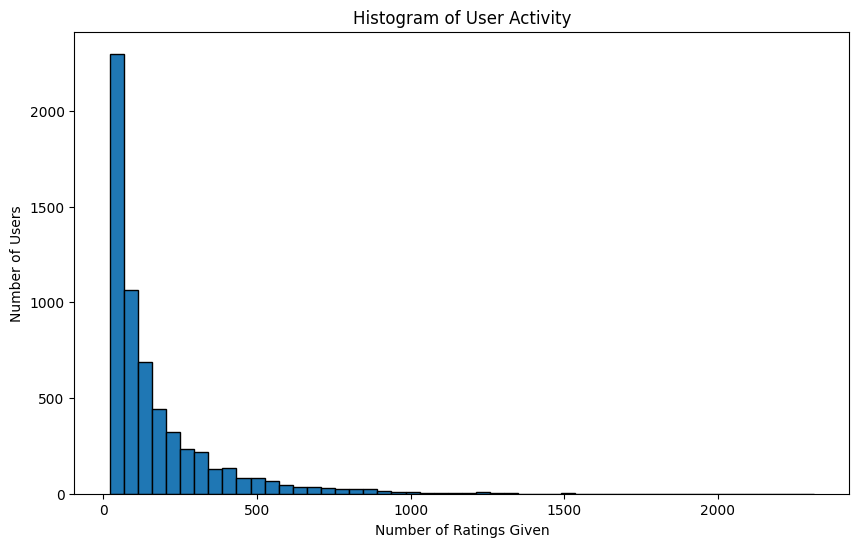

In [24]:
import matplotlib.pyplot as plt

# Assuming all_ratings is your DataFrame
# Group by user_id and count the number of ratings for each user
user_activity = all_ratings.groupby('user_id')['ratings'].count()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(user_activity, bins=50, edgecolor='black')

# Adding titles and labels
plt.title('Histogram of User Activity')
plt.xlabel('Number of Ratings Given')
plt.ylabel('Number of Users')

# Show the plot
plt.show()

**Exercise**: Compute the average ratings for every movie and find the top 20 highly rated movies. Include the list of 20 highly rated movies and their ratings in your report. Are these highly rated movies popular?

In [25]:
import pandas as pd

# Calculating the average rating for each movie
average_ratings = all_ratings.groupby('item_id')['ratings'].mean()

# Converting the Series to a DataFrame
average_ratings = average_ratings.reset_index()

# Sort the movies by average rating in descending order
sorted_by_rating = average_ratings.sort_values(by='ratings', ascending=False)

# Get the top 20 highest rated movies
top_20_rated = sorted_by_rating.head(20)

# Merge with movies_names to get movie titles
top_20_rated = top_20_rated.merge(movies_names, on='item_id')

# Display the top 20 highly rated movies
print(top_20_rated)

# To check if these movies are popular, you can compare the item_id in top_20_rated with the item_id in top_10_movies from the previous popularity exercise
# This can be done by checking the intersection of both lists
popular_movies_ids = set(top_10_movies['item_id'])
highly_rated_movies_ids = set(top_20_rated['item_id'])
common_movies = popular_movies_ids.intersection(highly_rated_movies_ids)

# Display the common movies
print("Common movies in both highly rated and popular categories:", common_movies)

    item_id   ratings                                          item_name
0      3280  5.000000                                   Baby, The (1973)
1      3233  5.000000                               Smashing Time (1967)
2      3607  5.000000                           One Little Indian (1973)
3      3382  5.000000                             Song of Freedom (1936)
4      3881  5.000000                           Bittersweet Motel (2000)
5       989  5.000000          Schlafes Bruder (Brother of Sleep) (1995)
6      3656  5.000000                                       Lured (1947)
7      3172  5.000000                            Ulysses (Ulisse) (1954)
8      1830  5.000000                            Follow the Bitch (1998)
9       787  5.000000                 Gate of Heavenly Peace, The (1995)
10     3245  4.800000                I Am Cuba (Soy Cuba/Ya Kuba) (1964)
11       53  4.750000                                    Lamerica (1994)
12     2503  4.666667                            Ap

---
## Train, Validation, and Test Data

Now we will split the data in _train_, _val_ and _test_ be using a pre-defined function from [scikit-learn](http://scikit-learn.org/stable/)

In [26]:
#Split the data into train, validation and test
from sklearn.model_selection import train_test_split

ratings_trainval, ratings_test = train_test_split(all_ratings, test_size=0.1, random_state=42)

ratings_train, ratings_val = train_test_split(ratings_trainval, test_size=0.1, random_state=42)

In [27]:
user_id_train = ratings_train['user_id']
item_id_train = ratings_train['item_id']
rating_train = ratings_train['ratings']

user_id_test = ratings_test['user_id']
item_id_test = ratings_test['item_id']
rating_test = ratings_test['ratings']

In [28]:
movies_not_train = list(set(all_ratings['item_id']) -set(item_id_train))
movies_not_train_name=set(all_ratings.loc[movies_not_train]['item_name'])
print(movies_not_train_name)

{'Bodyguard, The (1992)', 'Star Wars: Episode IV - A New Hope (1977)', 'Inspector Gadget (1999)', 'Two if by Sea (1996)', 'Star Wars: Episode I - The Phantom Menace (1999)', 'Children of the Corn (1984)', 'Home Alone (1990)', 'Jackie Brown (1997)', 'Celluloid Closet, The (1995)', 'Rudy (1993)', 'Coneheads (1993)', 'Simple Plan, A (1998)', 'Great Escape, The (1963)', 'In & Out (1997)', 'Tomorrow Never Dies (1997)', 'Alien Nation (1988)', 'Naked Gun: From the Files of Police Squad!, The (1988)', 'Man Who Knew Too Little, The (1997)', 'Howards End (1992)', 'Princess Bride, The (1987)', 'Final Destination (2000)', 'Star Trek: The Wrath of Khan (1982)', 'Titanic (1997)', 'Mighty Ducks, The (1992)'}


We see that a few movies are not rated in the train set. For those movies, it is hard to predict their ratings accurately.

---
## Data Load and Batching

Use GPU if available.

In [29]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We define a function to return a triplet of user_num, item_num, rating from the dataframe.

In [30]:
def df_2_tensor(df, device):
    # return a triplet user_num, item_num, rating from the dataframe
    user_num = np.asarray(df['user_num'])
    item_num = np.asarray(df['item_num'])
    rating = np.asarray(df['ratings'])
    return torch.from_numpy(user_num).to(device), torch.from_numpy(item_num).to(device), torch.from_numpy(rating).to(device)

Below, we construct 3 tensors containing the `user_num`, `item_num` and `rating` for the training set. All tensors have the same shape so that `train_user_num[i]` watched `train_item_num[i]` and gave a rating of `train_rating[i]`.

In [31]:
train_user_num, train_item_num, train_rating = df_2_tensor(ratings_train,device)

We now do the same thing for the validation and test sets.

In [32]:
val_user_num, val_item_num, val_rating = df_2_tensor(ratings_val,device)
test_user_num, test_item_num, test_rating = df_2_tensor(ratings_test,device)

Now you need to construct a dataset and a dataloader. For this, you can define a first function taking as arguments the tensors defined above and returning a list (Hint: you may use the [zip function](https://www.w3schools.com/python/ref_func_zip.asp)); then a second function taking as argument a dataset, the batchsize and a boolean for the shuffling.

**Exercise**: Filling in the missing code below to construct dataset and dataloader.

In [33]:
def tensor_2_dataset(user,item,rating):
    # your code here
    # Hint: check the zip function
    dataset = list(zip(user, item, rating))
    return dataset

from torch.utils.data import DataLoader
def make_dataloader(dataset,bs,shuffle):
    # your code here
    dataloader = DataLoader(dataset, batch_size=bs, shuffle=shuffle)
    return dataloader

In [34]:
train_dataset = tensor_2_dataset(train_user_num,train_item_num, train_rating)
val_dataset = tensor_2_dataset(val_user_num,val_item_num,val_rating)
test_dataset = tensor_2_dataset(test_user_num, test_item_num, test_rating)

Load the train, validation, and test data in batchs of size 1024.

In [35]:
train_dataloader = make_dataloader(train_dataset,1024,True)
val_dataloader = make_dataloader(val_dataset,1024, False)
test_dataloader = make_dataloader(test_dataset,1024,False)

---
## The model



In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

We will use some custom embeddings defined as below.

In [37]:
class ScaledEmbedding(nn.Embedding):
    """
    Embedding layer that initialises its values
    to using a normal variable scaled by the inverse
    of the embedding dimension.
    """
    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.normal_(0, 1.0 / self.embedding_dim)
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)


class ZeroEmbedding(nn.Embedding):
    """
    Used for biases.
    """

    def reset_parameters(self):
        """
        Initialize parameters.
        """

        self.weight.data.zero_()
        if self.padding_idx is not None:
            self.weight.data[self.padding_idx].fill_(0.0)

### Creating Our Own Embedding Module

Now, we define the `Model_dot`(class to represents users and items. It's composed of a 4 `embedding` layers:

- a `(num_users x latent_dim)` embedding layer to represent users,
- a `(num_items x latent_dim)` embedding layer to represent items,
- a `(num_users x 1)` embedding layer to represent user biases, and
- a `(num_items x 1)` embedding layer to represent item biases.







**Exercise**: Fill the missing code to define the embeddings.

In [38]:
class DotModel(nn.Module):

    def __init__(self,
                 num_users,
                 num_items,
                 embedding_dim=32):

        super(DotModel, self).__init__()

        self.embedding_dim = embedding_dim

        # TODO: generate user and item embeddigns using ScaledEmbedding
        # your code
        self.user_embeddings = ScaledEmbedding(num_users, embedding_dim)
        self.item_embeddings = ScaledEmbedding(num_items, embedding_dim)

        # TODO: generate bias embeddigns using ZeroEmbedding
        # your code
        self.user_biases = ZeroEmbedding(num_users, 1)
        self.item_biases = ZeroEmbedding(num_items, 1)


    def forward(self, user_ids, item_ids):

        # TODO: compute and return the predicted rating based on the embedding vectors and biases.
        # your code
        user_embedding = self.user_embeddings(user_ids)
        item_embedding = self.item_embeddings(item_ids)
        user_bias = self.user_biases(user_ids).squeeze()
        item_bias = self.item_biases(item_ids).squeeze()

        # Compute the dot product and biases
        dot = (user_embedding * item_embedding).sum(1)
        rating = dot + user_bias + item_bias
        return rating

In [39]:
net = DotModel(total_user_id,total_item_id).to(device)

In [40]:
net

DotModel(
  (user_embeddings): ScaledEmbedding(6040, 32)
  (item_embeddings): ScaledEmbedding(3706, 32)
  (user_biases): ZeroEmbedding(6040, 1)
  (item_biases): ZeroEmbedding(3706, 1)
)

Now we check your network by taking  a batch from train loader.

In [41]:
batch_user, batch_item, batch_rating = next(iter(train_dataloader))
batch_user, batch_item, batch_rating = batch_user.to(device), batch_item.to(device), batch_rating.to(device)

In [42]:
predictions = net(batch_user, batch_item)
predictions.shape

torch.Size([1024])

We will use MSE loss defined below:

In [43]:
def regression_loss(predicted_ratings, observed_ratings):
    return ((observed_ratings - predicted_ratings) ** 2).mean()

In [44]:
loss=regression_loss(predictions,batch_rating)

In [45]:
loss

tensor(13.7422, device='cuda:0', grad_fn=<MeanBackward0>)

## Train and test the model

Now we define `FactorizationModel` class  that allows us to train and evaluate the explicit factorization models.


- The `fit` function should take as argument a dataloader for the training and a dataloader for the validation. At the end of each epoch, you run the test method on the validation set. Then you print both the loss on the training set and on the validation set to see if you are overfitting.

- Weight decay, or *L2 regularization*, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

**Exercise**: Filling in the missing code below to complete the training pass and validation pass.

In [46]:
class FactorizationModel(object):

    def __init__(self, embedding_dim=32, n_iter=10, l2=0.0,
                 learning_rate=1e-2, device=device, net=None, num_users=None,
                 num_items=None,random_state=None):

        self._embedding_dim = embedding_dim
        self._n_iter = n_iter
        self._learning_rate = learning_rate
        self._l2 = l2
        self._device = device
        self._num_users = num_users
        self._num_items = num_items
        self._net = net
        self._optimizer = None
        self._loss_func = None
        self._random_state = random_state or np.random.RandomState()


    def _initialize(self):
        if self._net is None:
            self._net = DotModel(self._num_users, self._num_items, self._embedding_dim).to(self._device)

        self._optimizer = optim.Adam(
                self._net.parameters(),
                lr=self._learning_rate,
                weight_decay=self._l2
            )

        self._loss_func = regression_loss

    @property
    def _initialized(self):
        return self._optimizer is not None


    def fit(self, dataloader, val_dataloader, verbose=True):
        if not self._initialized:
            self._initialize()

        valid_loss_min = np.Inf # track change in validation loss
        train_losses, valid_losses, valid_maes =[], [], [] # track train losses, valid loss, and valid maes over epoches

        for epoch_num in range(self._n_iter):
            tot_train_loss = 0.0
            ###################
            # train the model #
            ###################
            #TODO: trainining loop:
            # your code
            for batch_user, batch_item, batch_rating in dataloader:
              batch_user, batch_item, batch_rating = batch_user.to(self._device), batch_item.to(self._device), batch_rating.to(self._device)

              # Zero the gradients
              self._optimizer.zero_grad()
              # Compute predictions
              predictions = self._net(batch_user, batch_item)
              # Compute loss
              loss = self._loss_func(predictions, batch_rating.float())
              tot_train_loss += loss.item()
              # Backpropagation
              loss.backward()
              # Update weights
              self._optimizer.step()

            train_loss = tot_train_loss /len(dataloader)

            # Go to the validation loop
            valid_loss, valid_mae = self.test(val_dataloader)

            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
            valid_maes.append(valid_mae)

            if verbose:
                print('Epoch {}: loss_train {}, loss_val {}'.format(epoch_num, train_loss,valid_loss))

            if np.isnan(train_loss) or train_loss == 0.0:
                raise ValueError('Degenerate train loss: {}'.format(train_loss))

            #TODO: Saving model if validation loss has decreased
            # your code
            if valid_loss < valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(valid_loss_min, valid_loss))
                torch.save(self._net.state_dict(), 'best_model.pth')  # Save the model
                valid_loss_min = valid_loss

        return train_losses, valid_losses, valid_maes

    ######################
    # validate/Test the model #
    ######################
    def test(self,dataloader, verbose = False):
        self._net.eval()
        L1loss = torch.nn.L1Loss()
        tot_test_loss = 0.0
        tot_test_mae = 0.0

        # TODO: validation/testing loop
        # your code here (mae = mean absolute error)
        with torch.no_grad():  # Not track gradients
          for batch_user, batch_item, batch_rating in dataloader:
              batch_user, batch_item, batch_rating = batch_user.to(self._device), batch_item.to(self._device), batch_rating.to(self._device)
              # Compute predictions
              predictions = self._net(batch_user, batch_item)
              # Compute loss
              loss = self._loss_func(predictions, batch_rating.float())
              tot_test_loss += loss.item()
              # Compute MAE
              mae = L1loss(predictions, batch_rating.float())
              tot_test_mae += mae.item()

        test_loss = tot_test_loss / len(dataloader)
        test_mae = tot_test_mae / len(dataloader)
        if verbose:
            print(f"RMSE: {np.sqrt(test_loss)}, MAE: {test_mae}")
        return test_loss, test_mae

In [47]:
#TODO: Construct your model using FactorizationModel
# your code

model = FactorizationModel(
    embedding_dim=32,
    n_iter=30,  # Number of training epochs
    l2=0.001,  # L2 regularization
    learning_rate = 0.001,  # Learning rate
    num_users=total_user_id,  # Total number of users
    num_items=total_item_id  # Total number of items
)

**Exercise**: Train the model and plot the train losses and valid losses over epoches.
At which epoch, you would stop the training? Include the plot and your answer in the report.

In [ ]:
import matplotlib.pyplot as plt
train_losses, valid_losses, valid_maes = model.fit(train_dataloader, val_dataloader)
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.legend()
plt.show()

Epoch 0: loss_train 8.899166237525266, loss_val 3.9592735550620337
Validation loss decreased (inf --> 3.959274). Saving model ...
Epoch 1: loss_train 3.5109130198305305, loss_val 3.290020590478724
Validation loss decreased (3.959274 --> 3.290021). Saving model ...
Epoch 2: loss_train 3.2111386879526003, loss_val 3.1335795440457086
Validation loss decreased (3.290021 --> 3.133580). Saving model ...
Epoch 3: loss_train 3.09121930629316, loss_val 3.0410090441053566
Validation loss decreased (3.133580 --> 3.041009). Saving model ...


**Exercise**: Now, let's compute the RMSE and mean absolute error on the test data. Include your answers in your report.

In [ ]:
test_loss, test_mae = model.test(test_dataloader, verbose=True)
print("Test RMSE: {:f}, Test MAE: {:f}".format(test_loss, test_mae))

## Optimize your model and training

**Exercise**: Play with the hyperparameters (embedding_dim, n_iter, learning_rate, L2 regularization, etc) to beat the benchmarks presented in [Surprise](https://github.com/NicolasHug/Surprise). List the hyperparameters and the RMSE and MAE on test data in the report. Save the model state to `model_cf.pt` and submit it to Canvas.


In [ ]:
# Define each hyperparameter
embedding_dims = [64]
learning_rates = [1e-3]
l2_regs = [1e-5]
n_iters = [15]

best_rmse, best_mae, best_params = float('inf'), float('inf'), {}

# Loop through all possible combinations
for emb_dim in embedding_dims:
    for lr in learning_rates:
        for l2 in l2_regs:
            for n_iter in n_iters:
                model = FactorizationModel(embedding_dim=emb_dim, n_iter=n_iter, l2=l2, learning_rate=lr, device=device, num_users=total_user_id, num_items=total_item_id)
                train_losses, valid_losses, valid_maes = model.fit(train_dataloader, val_dataloader)
                val_rmse, val_mae = model.test(val_dataloader)

                if val_rmse < best_rmse:
                    best_rmse, best_mae, best_params = val_rmse, val_mae, {'embedding_dim': emb_dim, 'learning_rate': lr, 'l2': l2, 'n_iter': n_iter}
                    torch.save(model._net.state_dict(), 'model_cf.pt')

print(f"Best Params: {best_params}, Best RMSE: {best_rmse}, Best MAE: {best_mae}")

In [ ]:
best_model = FactorizationModel(**best_params, device=device, num_users=total_user_id, num_items=total_item_id)

# Ensure the model is initialized
best_model._initialize()

# Now load the saved model state
best_model._net.load_state_dict(torch.load('model_cf.pt'))

# Evaluate the model on the test set
test_rmse, test_mae = best_model.test(test_dataloader, verbose=True)

Here is comparison between the best benckmarks in [Surprise](https://github.com/NicolasHug/Surprise) and your model after hyperparameters tunning.

| [Movielens 1M](https://grouplens.org/datasets/movielens/1m)                                                                             |   RMSE |   MAE |
|:----------------------------------------------------------------------------------------------------------------------------------------|-------:|------:|
| [SVD++ (cache_ratings=False)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| [SVD++ (cache_ratings=True)](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVDpp)  |  0.862 | 0.672 |
| **Yours**|  **XXX** | **XXX** |



## Interpreting Biases

Now you need to rank the movies according to their bias. For this, you need to recover the biases of the movies, make a list of the pairs `[name of the movie, its bias]` and then sort this list according to the biases. You can use the method sort of a list.

**Exercise**: What are your top 10 movies with the largest values of movie bias? What do you think about this ranking? Include your answers in your report.

In [ ]:
#TODO: retreive the bias of the movies from your optimized model and store it in the numpy array item_bais_np
item_bias_np = best_model._net.item_biases.weight.detach().cpu().numpy()
item_bias_np = item_bias_np.squeeze()

In [ ]:
# construct a dictionary that maps item_num to item_name, and vice versa
numitem_2_name = {i:name for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}
name_2_numitem = {name:i for name,i in np.asarray(all_ratings[['item_name', 'item_num']])}

In [ ]:
# Construct a list of movie names and the corresponding bias.
list_name_bias = [[name, item_bias_np[name_2_numitem[name]]] for name in list(ratings_train['item_name'].unique())]

In [ ]:
#TODO: sort the movie names by biases and output the top 10 movie names with the largest biases.
# your code
list_name_bias.sort(key=lambda x: x[1], reverse=True)  # Sort by bias in descending order
top_10_movies_by_bias = list_name_bias[:10]  # Select top 10 movies
top_10_movies_by_bias

## PCA of movies' embeddings

Now you can also play with the embeddings learned by your algorithm for the movies.

It is not quite so easy to directly interpret the embedding matrices. There are just too many factors for a human to look at. But there is a technique that can pull out the most important underlying *directions* in such a matrix, called *principal component analysis* (PCA). We will not be going into this in detail in this class, because it is not particularly important for you to understand to be a deep learning practitioner. We can visualize the movie embeddings based on two of the strongest PCA components.

**Exercise**: Do you observe anything interesting from the movie embeddings? Include the plot of the movie embeddings and your answer in your report.

In [ ]:
from sklearn.decomposition import PCA
from operator import itemgetter

In [ ]:
#TODO: retrive your movie embedding vectors and store them as a numpy matrix
item_emb_np = best_model._net.item_embeddings.weight.detach().cpu().numpy()

In [ ]:
#Here we perform PCA to extract the 4 principal components
pca = PCA(n_components=4)
latent_fac = pca.fit_transform(item_emb_np)

Next, we plot the embeddings of the top 80 mostly rated movies using the second and third principal components.

In [ ]:
#Here we get the top 1000 mostly rated movies
g = all_ratings.groupby('item_name')['ratings'].count()
most_rated_movies = g.sort_values(ascending=False).index.values[:1000]
# we get the corresponding movie numbers
most_rated_movies_num = [name_2_numitem[n] for n in most_rated_movies]

In [ ]:
nums = most_rated_movies_num[:80]
txt_movies_names = [numitem_2_name[i] for i in nums]
X = latent_fac[nums,1]
Y = latent_fac[nums,2]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(txt_movies_names, X, Y):
    plt.text(x+0.01,y-0.01,i, fontsize=11)
plt.show()

## Predict your own ratings

Now that we have succesfully trained a model, let's see how to deal with the situation where we have a new user. How can we make recommendations to new users?

It turns out that we can utilize the learned movie embedding vectors to estimate new users' embedding vector, based on a few ratings from them. You may have noticed that when you sign up for services such as Pandora and Netflix, they tend to ask you a few questions about what movie or music you like; this is how they come up with your initial collaborative filtering recommendations.


- First, give 40 ratings between 1-5 to the movies that your team watched before among the mostly rated movies;

In [ ]:
import random

my_ratings = {movie: random.randint(1, 5) for movie in random.sample(list(most_rated_movies), 40)}
my_ratings


- Second, compute your own embedding vector `my_emb_np` and `my_emb_bias` by running an ordinary least squares with L_2 regularization based on your ratings and the previously computed movie embedding vectors. In other words, `item_emb_np` is the co-variate and your own 40 ratings are the response.

  Hint: you may use the [ridge regression (linear regression with L2 regularization)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) in the sklearn package.

In [ ]:
#TODO: compute your own embedding vector and bias

from sklearn.linear_model import Ridge
import numpy as np

rated_movie_embeddings = np.array([item_emb_np[name_2_numitem[movie]] for movie in my_ratings if movie in name_2_numitem])
my_ratings_array = np.array([my_ratings[movie] for movie in my_ratings if movie in name_2_numitem])

ridge = Ridge(alpha=1.0)
ridge.fit(rated_movie_embeddings, my_ratings_array)

my_emb_np = ridge.coef_  # Embedding
my_emb_bias = ridge.intercept_  # Bias


-  Then compute the predicted ratings for all movies using your embedding vectors and biases, together with the movie embedding vectors and biases.

In [ ]:
# compute pred_ratings

all_movie_embeddings = best_model._net.item_embeddings.weight.detach().cpu().numpy()
all_movie_biases = best_model._net.item_biases.weight.detach().cpu().numpy().squeeze()

# Compute predicted ratings for all movies
pred_ratings = np.dot(all_movie_embeddings, my_emb_np) + my_emb_bias + all_movie_biases

- Finally, among all movies that you haven't rated, output the top 10 movies with the highest predicted ratings.

In [ ]:
# output the top 10 movies with the highest predicted ratings.

# All movies in the dataset
all_movies = set(name_2_numitem.keys())

# Movies you have rated
rated_movies = set(my_ratings.keys())

# Movies you haven't rated
unrated_movies = all_movies - rated_movies

# Get the indices (numbers) of unrated movies
unrated_movies_indices = [name_2_numitem[movie] for movie in unrated_movies]

# Predicted ratings for unrated movies
unrated_pred_ratings = pred_ratings[unrated_movies_indices]

# Get the indices of top 10 ratings among unrated movies
top_10_unrated_indices = np.argsort(unrated_pred_ratings)[-10:]

# Map these indices to movie names
top_10_unrated_movie_names = [numitem_2_name[unrated_movies_indices[idx]] for idx in top_10_unrated_indices]

print("Top 10 Unrated Movies with Highest Predicted Ratings:")
for movie_name in top_10_unrated_movie_names:
    print(movie_name)

**Question**: How do you feel about the predicted ratings? Do you like these top 10 movies? Include your answer in your report.

---
## Movie valuation

The rating data provided the company like Netflix information about the value of a movie that was not available to movie production studios. The collaborative filting algorithm allows Netflix to accurately value the content in a data-driven manner. For example, if Netflix were offered the opportunity to license *Toy Story (1995)*, it would need to provide Disney an initial quote of the license fee. Traditional methods suggest looking at box office returns of *Toy Story* franchise and projecting the potential value of the film.

In this following, we will explore a novel approach to determine the valuation of a movie based on the predicted ratings. We make the following simplifying assumpitons (Note that these assumptions can be certainly relaxed with more complicated procedures and data):

- **Netflix are focusing on the top 1000 active users and 1000 popular movies (with the most number of observed ratings).** In other words, in the following movie valuation calculation, we just consider the top 1000 activie users and 1000 popular movies, disregarding the rest.

- For each user, the total amount of viewing time is proportional to the number of observed ratings. In other words, more active users spend more time on Netflix;

- For each given user, the viewing time across different movies follow a [Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), that is

  $$
    \text{Viewtime of movie $i$} \propto \frac{1}{\text{rank of } i }
  $$
  Here the rank of $i$ is determined by sorting the **predicted rating** of movie $i$ by the user in descending order. In other words, the user spend less time on watching movies with lower ratings.

- Netflix has a fixed total budget of 1 Billion dollars to license the content;

- Netflix estimates the value of a movie based on the expected share of customer viewing time of the movie on its platform:
$$
\text{Value of a movie $i$ } = \frac{\text{View time of movie $i$ of all users}}{\text{Total view time of all users} } \times \text{Total content license budget}
$$


### Compute the value of each movie

In [ ]:
# Get indices for top 1000 active users and top 1000 mostly rated movies
top1000_user_num = pd.Series(all_ratings["user_num"].value_counts()[:1000].index, name="user_num")
top1000_item_num = pd.Series(all_ratings["item_num"].value_counts()[:1000].index, name="item_num")
# Construct dataframes for storing predicted ratings
pred_ratings = pd.merge(top1000_user_num, top1000_item_num, how="cross")
cartesian_user_num = torch.from_numpy(np.asarray(pred_ratings["user_num"])).to(device)
cartesian_item_num = torch.from_numpy(np.asarray(pred_ratings["item_num"])).to(device)

In [ ]:
pred_ratings.head()

In [ ]:
# sanity check: # of rows in pred_ratings == # of active users (1000) x # of popular items (1000)
pred_ratings.shape[0] == 1000 * 1000

In [ ]:
#TODO: use your optimized model to compute the predicted ratings among the top 1000 active users and top 1000 popular movies

best_model._initialize()
best_model._net.load_state_dict(torch.load('model_cf.pt'))

with torch.no_grad():
    predicted_ratings_tensor = best_model._net(cartesian_user_num, cartesian_item_num)
predicted_ratings_array = predicted_ratings_tensor.cpu().numpy()

pred_ratings["pred_ratings"] = predicted_ratings_array

In [ ]:
# Each user's total viewtime is stored in Series user_total_viewtime
user_total_viewtime = all_ratings["user_num"].value_counts()[:1000] / all_ratings["user_num"].value_counts()[:1000].sum()
user_total_viewtime.name = "user_total_viewtime"
user_total_viewtime.index.name = "user_num"
pred_ratings = pd.merge(pred_ratings, user_total_viewtime, left_on="user_num", right_on="user_num", how="left")

In [ ]:
pred_ratings.head()

In [ ]:
# Each user per each movie viewtime: pred_all_ratings["user_item_viewtime"] = ["1/user_rank"] / ["sum(1/user_rank)"] * ["user_total_viewtime"]
# these wordy codes are to reduce RAM consumption otherwise Colab may crush
pred_ratings["1/user_rank"] = 1/pred_ratings.groupby("user_num")["pred_ratings"].rank(method = "min", ascending = False)
sum_inverse_user_rank = pred_ratings.groupby("user_num")["1/user_rank"].sum()
sum_inverse_user_rank.name = "sum(1/user_rank)"
pred_ratings = pd.merge(pred_ratings, sum_inverse_user_rank, left_on="user_num", right_on="user_num", how="left")
pred_ratings["user_item_viewtime"] = pred_ratings["1/user_rank"] / pred_ratings["sum(1/user_rank)"] * pred_ratings["user_total_viewtime"]

In [ ]:
pred_ratings

In [ ]:
# sanity check: sum of user_item_viewtime == 1
pred_ratings["user_item_viewtime"].sum()

In [ ]:
# compute each movie's value
budget =  1000000000
#TODO: compute and store the values of movies based on pred_ratings
movie_viewtime_sum = pred_ratings.groupby("item_num")["user_item_viewtime"].sum()
movie_values = movie_viewtime_sum * budget
movie_values.name = "item_value"

In [ ]:
# replace item_num by item_name
movie_values = movie_values.to_frame()
movie_values["item_name"] = [numitem_2_name[item_num] for item_num in movie_values.index]
movie_values = movie_values.set_index("item_name").squeeze(axis=1)

In [ ]:
movie_values.head()

In [ ]:
# sanity check: sum of movie values == budget
movie_values.sum() == budget

### Output the top valued movies

**Question**: Include your answer in the report.

- What is your estimated value of *Toy Story (1995)*?

- What are the top 10 mostly valued movies?


In [ ]:
# your code
toy_story_value = movie_values["Toy Story (1995)"]
print("Estimated value of Toy Story (1995):", toy_story_value)
# Get the top 10 most valued movies
top_10_valued_movies = movie_values.sort_values(ascending=False).head(10)
print("Top 10 Mostly Valued Movies:")
print(top_10_valued_movies)


### Compare the output with the mostly rated movies. Identify the discrepancies.

**Question**: Include your answers in your report.

- What are the movies that are top 30 rated but not in top 30 valued?
- What do you think about this approach of movie valuation? How does it compare with the approach based on the popularity of the movies?




In [ ]:
print("Movies top 30 rated but not in top 30 valued:")
for movie_id in rated_not_valued:
    # Check if the movie_id exists in the movies_names DataFrame
    if movie_id in movies_names['item_id'].values:
        movie_name = movies_names.loc[movies_names['item_id'] == movie_id, 'item_name'].iloc[0]
        print(movie_name)
    else:
        print(f" {movie_id}.")
